In [19]:
import os
import sys
import numpy as np
# import psycopg2
import sqlalchemy
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(
#     context='paper',
#     font_scale=8/8.8,
    context="talk",
    style='ticks',
    color_codes=True,
    rc={'legend.frameon': False})

plt.rcParams['svg.fonttype'] = 'none'

%matplotlib inline

In [20]:
print(os.getcwd())
sys.path.append('../../')
import rlmolecule

/home/pstjohn/Research/rlmolecule/examples/stable_radical_optimization


In [21]:
# connect to the db
dbname = "bde"
port = "5432"
host = "yuma.hpc.nrel.gov"
user = "rlops"
# read the password from a file
passwd_file = '/projects/rlmolecule/rlops_pass'
with open(passwd_file, 'r') as f:
    passwd = f.read().strip()

drivername = "postgresql+psycopg2"
engine_str = f'{drivername}://{user}:{passwd}@{host}:{port}/{dbname}'
engine = sqlalchemy.create_engine(engine_str, execution_options={"isolation_level": "AUTOCOMMIT"})

# Initial Results
Eagle is really backed up, so these results are from multiple runs on the debug queue (which has a 1 hr time limit)

In [159]:
# run_id = 'stable_radical_optimization'
run_id = 'stable_radical_optimization_psj_NN_l2'

In [160]:
# load the games played
from rlmolecule.sql import Base, Session
from rlmolecule.sql.tables import GameStore, RewardStore, StateStore
Session.configure(bind=engine)
session = Session()
# df = pd.read_sql(session.query(GameStore).filter_by(run_id=run_id).statement, session.bind)

# df['time_hours'] = (df.time - df.time.min()).apply(lambda x: x.total_seconds() / 3600)
# df = df.sort_values('time_hours')
# df_games = df
# df_games.reset_index(drop=True, inplace=True)
# df_games.head()

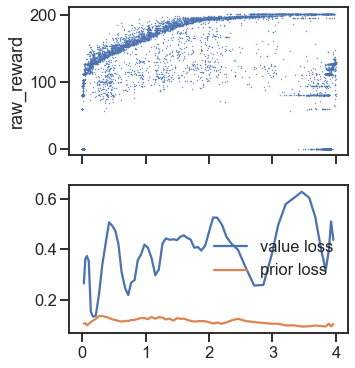

In [161]:
df = pd.read_sql(session.query(GameStore).filter_by(run_id=run_id).statement, session.bind)
df['time_hours'] = (df.time - df.time.min()).apply(lambda x: x.total_seconds() / 3600)
df = df.sort_values('time_hours')

log = pd.read_csv(f"policy_checkpoints/{run_id}/log.csv")
log['time'] = pd.to_datetime(log.time) - df.time.min()
log['time_hours'] = (log.time).apply(lambda x: x.total_seconds() / 3600)

f, ax = plt.subplots(nrows=2, sharex=True, figsize=(5,6))

ax[0].plot(df.time_hours, df.raw_reward, '.', ms=.75, label='games')
ax[0].set_ylabel("raw_reward")

ax[1].plot(log.time_hours, log.policy_wrapper_loss, label='value loss')
ax[1].plot(log.time_hours, log.policy_wrapper_1_loss, label='prior loss')
# ax.set_xlabel("Epoch")
plt.legend()

In [162]:
calc_times = pd.concat(df.execution_statistics.apply(pd.DataFrame.from_dict).tolist()).reset_index().groupby('index').sum()
calc_times

,execution_time,execution_count
index,,
calc_reward,1.637386e+04,1008855
get_next_actions,2.206837e+06,22745332


In [163]:
calc_times / calc_times.iloc[0]

,execution_time,execution_count
index,,
calc_reward,1.0000,1.00000
get_next_actions,134.7781,22.54569


In [164]:
calc_times['execution_time'] / 3600

index
calc_reward           4.548294
get_next_actions    613.010416
Name: execution_time, dtype: float64

In [165]:
calc_times['execution_time'] / calc_times['execution_count']

index
calc_reward         0.016230
get_next_actions    0.097024
dtype: float64

# Measure the spin, buried volume, and draw the molecule

TODO: Need to join the tables, and unpickle the state to get the smile strings from the state

In [150]:
run_id

'stable_radical_optimization_psj_NS_l2'

In [166]:
# look at some of the top rewards
df_rewards = pd.read_sql(session.query(RewardStore).filter_by(run_id=run_id).order_by(
    RewardStore.reward.desc()).limit(1000).statement, session.bind)

In [168]:
df_rewards['smiles'] = df_rewards.data.apply(lambda x: x['smiles'])
df_rewards.head().data

0    {'max_spin': '0.27308857', 'spin_buried_vol': ...
1    {'max_spin': '0.2844184', 'spin_buried_vol': '...
2    {'max_spin': '0.2519084', 'spin_buried_vol': '...
3    {'max_spin': '0.27014896', 'spin_buried_vol': ...
4    {'max_spin': '0.28944543', 'spin_buried_vol': ...
Name: data, dtype: object

In [171]:
df_rewards.iloc[3]

digest    6d6665e273f52fe106464271041b7bb1aa17794f1f2790...
hash                                    7345119961777448323
run_id                stable_radical_optimization_psj_NN_l2
time                             2021-05-20 12:09:28.237395
reward                                           199.273039
data      {'max_spin': '0.27014896', 'spin_buried_vol': ...
smiles                    CC1=C2CCC(C)(C)N([NH])C2=C(C)C1=O
Name: 3, dtype: object

In [170]:
df_rewards.iloc[3]['data']

{'max_spin': '0.27014896',
 'spin_buried_vol': '62.780487',
 'ionization_energy': '0.9034696817398071',
 'electron_affinity': '-0.284115195274353',
 'bde': '75.97232',
 'bde_diff': '0.0',
 'forced_terminal': True,
 'smiles': 'CC1=C2CCC(C)(C)N([NH])C2=C(C)C1=O'}

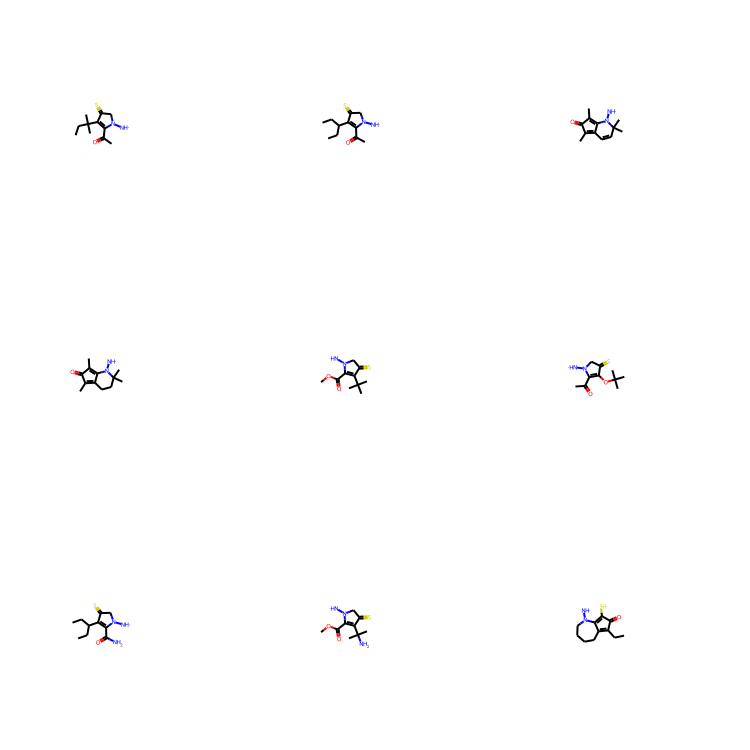

In [169]:
import rdkit
from rdkit.Chem.Draw import MolsToGridImage

mols = df_rewards.smiles.apply(rdkit.Chem.MolFromSmiles)
MolsToGridImage(mols[:9], subImgSize=(250,250))

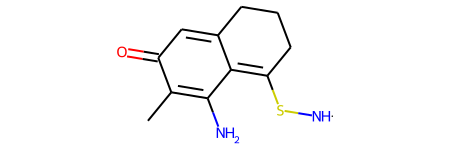

In [158]:
mols[3]

In [49]:
df_rewards.iloc[8]

digest    5b30333c54455874c63afd1d3e9ad4c102a8fc3097b0ec...
hash                                    6085149740507800563
run_id                 stable_radical_optimization_psj_NO_l
time                             2021-05-19 18:27:47.224522
reward                                           203.860452
data      {'max_spin': '0.22799496', 'spin_buried_vol': ...
smiles                     CC1(C)C=CC(O)=C(N=O)C(C)(C)N1[O]
Name: 8, dtype: object

In [ ]:
# Code for raster image drawing
import rdkit

from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import rdMolDraw2D
from rdkit.Chem.Draw import SimilarityMaps
from rdkit.Chem import rdDepictor
from IPython.display import SVG

In [ ]:
# row = pass_gng.sample(1, random_state=5).iloc[0]
# mol = Chem.MolFromSmiles(row.smiles)

d = rdMolDraw2D.MolDraw2DSVG(400, 400)
SimilarityMaps.GetSimilarityMapFromWeights(mol, [float(i) for i in pred_spins(mol)], draw2d=d)
d.FinishDrawing()
SVG(d.GetDrawingText())

# Leftover code from augmenting_reward branch:

In [ ]:
with psycopg2.connect(**config.dbparams) as conn:
    experiment_ids = pd.read_sql_query("select distinct experiment_id from {}_game".format(config.sql_basename), conn)
    
experiment_ids

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(13, 3), sharex=True, sharey=True)

optimal = []
for ax, atom in zip(axs, ['C', 'N', 'O', 'S']):
    
    ax.plot(rew_df[rew_df.atom_type == atom]['max_spin'],
            rew_df[rew_df.atom_type == atom]['buried_vol'], '.', ms=1, alpha=.1, label='All radicals')
    
    ax.plot(stable_max_spin[stable_max_spin['atom-sym'] == atom]['fractional_spin'],
            stable_max_spin[stable_max_spin['atom-sym'] == atom]['bur-vol'],
            '.', label='Experimentally stable')
    
    ax.plot(pass_gng[pass_gng.atom_type == atom]['max_spin'],
            pass_gng[pass_gng.atom_type == atom]['buried_vol'], '.', ms=1, label='Pass GNG')
    
    ax.set_title(atom)
    
axs[1].set_xlabel('Max Fractional Spin')
axs[0].set_ylabel('Buried volume\nat max spin')

axs[-1].legend(loc='upper left', fontsize=12, markerscale=2)
sns.despine()    

In [ ]:
from matplotlib.patches import Polygon

fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(111, aspect='equal')

ax.plot(rew_df['ea'], rew_df['ie'], '.', ms=1, alpha=.1)
ax.plot(pass_gng['ea'], pass_gng['ie'], '.', ms=1, color='g')

ax.add_patch(Polygon(np.array([(-.5, 1.2), (-.5, 0.5), (.2, 1.2)]), facecolor='none', zorder=5, edgecolor='r', lw=3, ls='--'))
ax.set_xlim([-1.5, 1.5])
ax.set_ylim([-1, 2])

ax.axvspan(-.5, .2, facecolor='.8', edgecolor='none')
ax.axhspan(.5, 1.2, facecolor='.8', edgecolor='none')

ax.set_xlabel(r'$E_{1/2}^o$, EA (V)')
ax.set_ylabel(r'$E_{1/2}^o$, IE (V)')

In [ ]:
fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(111)

sns.kdeplot(rew_df.bde, label='All radicals')
sns.kdeplot(pass_gng.bde, label='Pass GNG', color='g')
plt.xlabel('BDE')
plt.ylabel('Frequency')

In [ ]:
df = rew_df[~rew_df.index.isin(pass_gng.index)].sort_values('real_reward', ascending=False)

In [ ]:
pass_gng.sample(10)

In [ ]:
rew_df[rew_df.real_reward > 200]

In [ ]:
rew_df.real_reward.max()

In [ ]:
plt.hist(rew_df.ie - rew_df.ea, bins=20)

In [ ]:
fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(111)

plt.hist(rew_df.real_reward, label='All radicals', range=(0, 225))
plt.hist(pass_gng.real_reward, label='Pass GNG', color='g', range=(0, 225))
plt.xlabel('Reward')
plt.ylabel('Frequency')

In [ ]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
import nfp

In [ ]:
from reward import predict, stability_model
from alphazero.node import Node

def pred_spins(mol):
    spins, _ = predict(stability_model, 
        {key: tf.constant(np.expand_dims(val, 0))
         for key, val in Node(mol).policy_inputs.items()})
    
    return spins.numpy().flatten()

In [ ]:
# Load the game buffer
with psycopg2.connect(**config.dbparams) as conn:
    df = pd.read_sql_query("select * from {}_game where experiment_id = %s".format(
        config.sql_basename), conn, params=(config.experiment_id,))
    
# Load the policy training history
try:
    log = pd.read_csv(os.path.join(config.checkpoint_filepath, 'log.csv'))
    log['time'] = pd.to_datetime(log.time)
except Exception:
    log = None

df['time_hours'] = (df.time - df.time.min()).apply(lambda x: x.total_seconds() / 3600)

if log is not None:
    log['time_hours'] = (log.time - df.time.min()).apply(lambda x: x.total_seconds() / 3600)

df = df.sort_values('time_hours')

fig, axs = plt.subplots(sharex=True, nrows=2, figsize=(2.75, 2.5), dpi=150)

axs[0].plot(df.time_hours, df.real_reward, '.', ms=.75, label='games')
axs[0].plot(df.time_hours, df.real_reward.rolling(250, min_periods=50).quantile(.75), label='$r_{75}$')

if log is not None:
    axs[1].plot(log.time_hours, log.policy_wrapper_loss, label='value loss')
    axs[1].plot(log.time_hours, log.policy_wrapper_1_loss, label='prior loss')

axs[0].legend(loc='upper right', ncol=2, borderpad=0, borderaxespad=0.3, bbox_to_anchor=(1., 1.1), markerscale=10)
axs[1].legend(ncol=2, borderpad=0, borderaxespad=0.3)

axs[0].set_ylim([0, 250])

axs[0].set_ylabel('Reward')
axs[1].set_ylabel('Policy Training')
axs[1].set_xlabel('Time (hours)')

axs[1].set_ylim([0, .7])
axs[1].set_xlim([-.01, 4])

plt.tight_layout()
sns.despine(offset=5, trim=True)
# plt.savefig('20210204_policy_loss.svg')

In [ ]:
with psycopg2.connect(**config.dbparams) as conn:
    experiment_ids = pd.read_sql_query("select distinct experiment_id from {}_game".format(config.sql_basename), conn)
    
experiment_ids

In [ ]:
# Load the reward buffer to plot the optimal molecules
with psycopg2.connect(**config.dbparams) as conn:
    rew_df = pd.read_sql_query("select * from {}_reward".format(config.sql_basename), conn)

rew_df.shape

In [ ]:
rew_df.sort_values('real_reward', ascending=False).head(20)

In [ ]:
stable_df = pd.read_csv('/home/pstjohn/Research/20200608_redox_calculations/stable_radicals/spin-charges-bur-vol-stable-radicals-all-atoms-with-smi.csv')

stable_df_noH = stable_df[~stable_df['atom-sym-idx'].str.startswith('H')]
stable_df['fractional_spin'] = stable_df_noH.groupby('File')['spin-density'].transform(lambda x: x.abs() / x.abs().sum())

stable_idx_max_spin = stable_df.groupby('File').fractional_spin.idxmax()
stable_max_spin = stable_df.loc[stable_idx_max_spin]

In [ ]:
from rdkit import Chem

In [ ]:
stable_df['smiles'] = stable_df.Smiles.apply(lambda x: Chem.MolToSmiles(Chem.MolFromSmiles(x)))

In [ ]:
rew_df[rew_df.smiles.isin(stable_df.smiles)]

In [ ]:
pass_gng = rew_df[(rew_df.bde < 80) & (rew_df.bde > 60) &
                  (rew_df.ie < 1.2) & (rew_df.ea > -.5) &
                  ((rew_df.ie - rew_df.ea) > 1) &
                  ((rew_df.buried_vol + 50 * (1 - rew_df.max_spin)) > 100.)]

In [ ]:
pass_gng.shape

In [ ]:
pass_gng.to_csv('20210109_gng_radicals.csv.gz', compression='gzip')

In [ ]:
from reward import redox_model, predict

In [ ]:
from alphazero.node import Node

In [ ]:
import tensorflow as tf

In [ ]:
def pred_redox(smiles):
    return predict(redox_model,
        {key: tf.constant(np.expand_dims(val, 0))
         for key, val in Node(rdkit.Chem.MolFromSmiles(smiles)).policy_inputs.items()}).numpy().flatten()

In [ ]:
from tqdm import tqdm
tqdm.pandas()

In [ ]:
redox = pass_gng.smiles.progress_apply(pred_redox)

In [ ]:
plt.plot(np.vstack(redox.values)[:, 0], pass_gng.ie, '.')

In [ ]:
(pass_gng.ie - np.vstack(redox.values)[:, 0]).abs().mean()

In [ ]:
Node(rdkit.Chem.MolFromSmiles('CC(=S)C1=C(C)[CH]CCC1(C)C')).policy_inputs

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(13, 3), sharex=True, sharey=True)

optimal = []
for ax, atom in zip(axs, ['C', 'N', 'O', 'S']):
    
    ax.plot(rew_df[rew_df.atom_type == atom]['max_spin'],
            rew_df[rew_df.atom_type == atom]['buried_vol'], '.', ms=1, alpha=.1, label='All radicals')
    
    ax.plot(stable_max_spin[stable_max_spin['atom-sym'] == atom]['fractional_spin'],
            stable_max_spin[stable_max_spin['atom-sym'] == atom]['bur-vol'],
            '.', label='Experimentally stable')
    
    ax.plot(pass_gng[pass_gng.atom_type == atom]['max_spin'],
            pass_gng[pass_gng.atom_type == atom]['buried_vol'], '.', ms=1, label='Pass GNG')
    
    ax.set_title(atom)
    
axs[1].set_xlabel('Max Fractional Spin')
axs[0].set_ylabel('Buried volume\nat max spin')

axs[-1].legend(loc='upper left', fontsize=12, markerscale=2)
sns.despine()    

In [ ]:
from matplotlib.patches import Polygon

fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(111, aspect='equal')

ax.plot(rew_df['ea'], rew_df['ie'], '.', ms=1, alpha=.1)
ax.plot(pass_gng['ea'], pass_gng['ie'], '.', ms=1, color='g')

ax.add_patch(Polygon(np.array([(-.5, 1.2), (-.5, 0.5), (.2, 1.2)]), facecolor='none', zorder=5, edgecolor='r', lw=3, ls='--'))
ax.set_xlim([-1.5, 1.5])
ax.set_ylim([-1, 2])

ax.axvspan(-.5, .2, facecolor='.8', edgecolor='none')
ax.axhspan(.5, 1.2, facecolor='.8', edgecolor='none')

ax.set_xlabel(r'$E_{1/2}^o$, EA (V)')
ax.set_ylabel(r'$E_{1/2}^o$, IE (V)')

In [ ]:
fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(111)

sns.kdeplot(rew_df.bde, label='All radicals')
sns.kdeplot(pass_gng.bde, label='Pass GNG', color='g')
plt.xlabel('BDE')
plt.ylabel('Frequency')

In [ ]:
df = rew_df[~rew_df.index.isin(pass_gng.index)].sort_values('real_reward', ascending=False)

In [ ]:
pass_gng.sample(10)

In [ ]:
rew_df[rew_df.real_reward > 200]

In [ ]:
rew_df.real_reward.max()

In [ ]:
plt.hist(rew_df.ie - rew_df.ea, bins=20)

In [ ]:
fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(111)

plt.hist(rew_df.real_reward, label='All radicals', range=(0, 225))
plt.hist(pass_gng.real_reward, label='Pass GNG', color='g', range=(0, 225))
plt.xlabel('Reward')
plt.ylabel('Frequency')

In [ ]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
import nfp

In [ ]:
from reward import predict, stability_model
from alphazero.node import Node

def pred_spins(mol):
    spins, _ = predict(stability_model, 
        {key: tf.constant(np.expand_dims(val, 0))
         for key, val in Node(mol).policy_inputs.items()})
    
    return spins.numpy().flatten()

In [ ]:
# Code for raster image drawing
import rdkit

from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import rdMolDraw2D
from rdkit.Chem.Draw import SimilarityMaps
from rdkit.Chem import rdDepictor
from IPython.display import SVG

In [ ]:
row = pass_gng.sample(1, random_state=5).iloc[0]
mol = Chem.MolFromSmiles(row.smiles)

d = rdMolDraw2D.MolDraw2DSVG(400, 400)
SimilarityMaps.GetSimilarityMapFromWeights(mol, [float(i) for i in pred_spins(mol)], draw2d=d)
d.FinishDrawing()
SVG(d.GetDrawingText())